# Implied Volatility Surface

In option pricing theory, implied volatility (IV) is the parameter that reconciles observed option prices with the Black–Scholes model. Naively, one might expect IV to remain constant for a fixed maturity, but in practice the curve is not flat. Instead, we observe a volatility smile (or skew): IV is lowest at the money (ATM) and rises toward the wings. This reflects the fact that markets systematically overprice extreme outcomes.

In this project, we extract IV from option quotes using two root-finding methods. The Newton–Raphson approach is efficient and works well for liquid, near-ATM options where convergence is stable. For contracts farther from the money or near arbitrage bounds, where Newton iterations can fail, we fall back to a bisection method, which is slower but more robust. With these tools, we construct smiles and surfaces across strikes and maturities, and compare their shapes across different stocks to study how market expectations and risks vary by ticker.

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import utils

import warnings
warnings.simplefilter("ignore", category = FutureWarning)

First, we extract the current risk-free interest rate from the FRED database:

In [2]:
r = utils.get_r()
print(f"Risk-free interest rate: {r}")

Risk-free interest rate: 0.03584965289369722


We pull today’s option chains for a selection of tech stocks, filtering out incomplete quotes and entries that fail no-arbitrage checks. Since `yfinance` does not provide historical option chains, this step is only reliable during U.S. market trading hours. Implied volatilities are then computed by numerically inverting the Black–Scholes formula for each option.

In [3]:
df = utils.fetch_chain(["MSFT", "GOOGL", "META", "TSLA"])
iv_df = utils.compute_iv(df, r = r)

Snapshot (UTC): 2025-10-01T15:17:42+00:00
Total: 14102, Valid: 10638


## The IV smile

To visualize the results, we plot implied volatility as a function of strike for a fixed maturity (the IV smile):

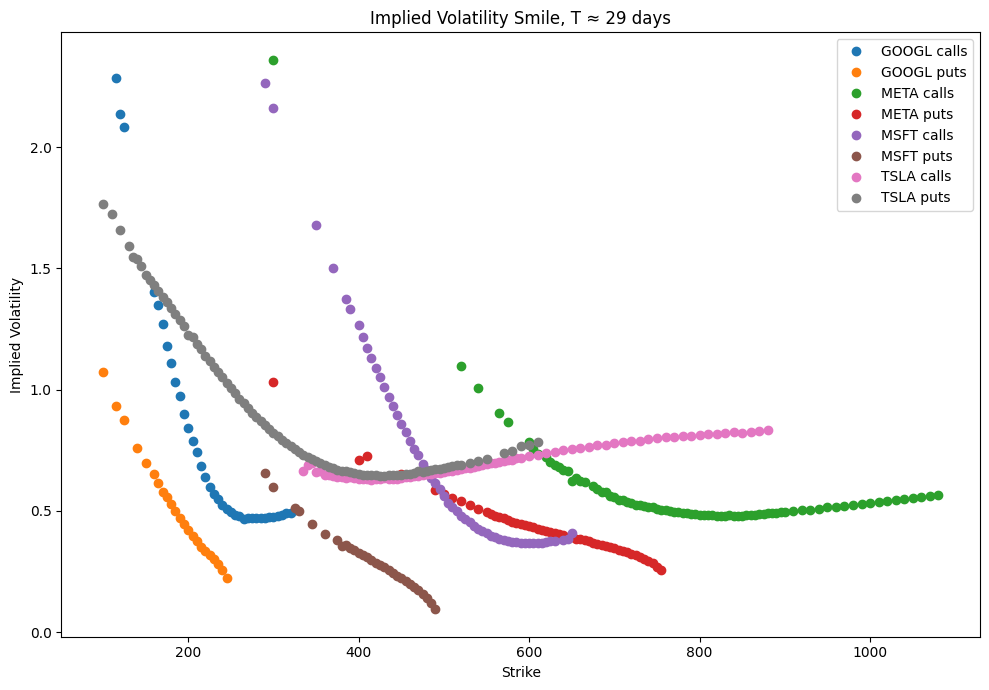

In [4]:
utils.plot_iv_smile(iv_df, target = 30)

More generally, we can plot a 3D surface of implied volatility as a function of maturity and moneyness \(K/F\), where the forward price is

$$
F = S \, e^{(r - q)T}.
$$

Using $K/F$ aligns different expiries around a common at-the-money point $(K/F \approx 1)$, which makes the plot more compact. To avoid clutter, we will show this surface for a single ticker.


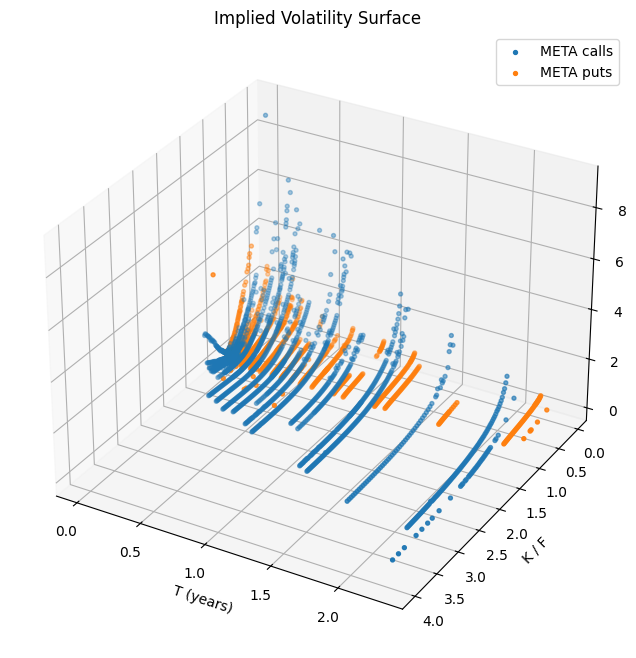

In [5]:
utils.plot_iv_surface(iv_df, tickers = "META")

An important feature of the plots is the apparent difference between calls and puts. Although theory (via put–call parity) links them closely, in practice their IVs can diverge due to liquidity imbalances and bid–ask noise. Calls also tend to terminate earlier at high strikes, since exchanges list fewer options far above the current stock price given limited demand. By contrast, puts usually extend further on the downside, leading to the observed asymmetry in strike coverage.

## At-the-money implied volatility

At-the-money implied volatility (ATM IV) refers to the IV of options with strikes closest to the current forward price. These options are typically the most liquid, since they are central to both hedging and speculation. Unlike deep in- or out-of-the-money contracts, which are distorted by risk premia for extreme events, ATM options provide the cleanest signal of consensus expectations. As a result, ATM IV is widely used as a benchmark for estimating future volatility of the underlying asset. Tracking ATM IV across maturities (the **term structure**) offers a useful measure of how the market’s expectations of volatility evolve over time.

We compute the ATM IV for all assets in the dataset and append it, together with the estimated forward-adjusted stock price, as additional columns.

In [6]:
utils.atm_iv(iv_df, method = "linear")

The term structure of ATM implied volatility for the selected stocks is shown below.

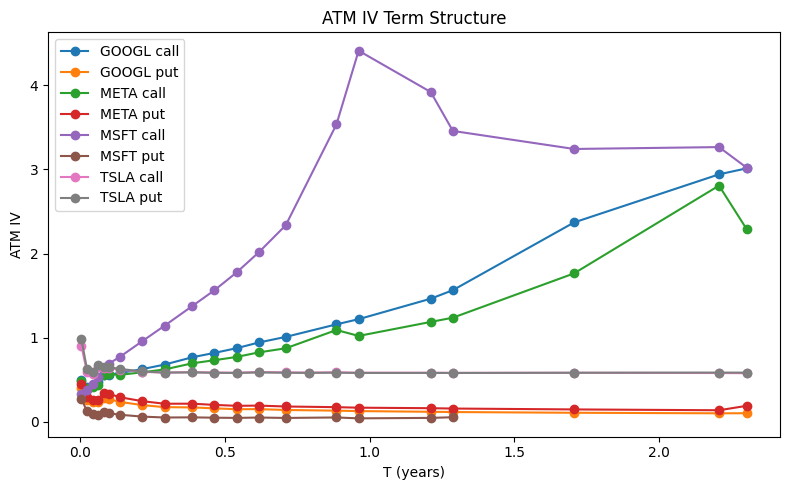

In [7]:
utils.plot_term_structure(iv_df)

In most cases, the ATM IV term structure is upward sloping: longer maturities carry higher implied volatility because uncertainty grows with time. It can flatten in calm markets or invert around short-term events, when near-term volatility is expected to exceed long-run levels.

MSFT’s downward slope at longer maturities could stem from several factors, with the most likely being:

- Data quality issues: illiquid long-dated options often have wide or stale quotes, distorting IV estimates.

- Event-driven effects: the market may be pricing elevated short-term volatility (earnings, regulatory risks, product cycles) but lower long-term uncertainty.

## Conclusions

In this project we extracted implied volatilities from option chains using numerical inversion of the Black–Scholes model, constructed smiles for fixed maturities, and built 3D volatility surfaces across strikes and expiries. We compared ATM IV term structures across several large tech stocks, noting typical upward slopes as well as anomalies such as dips or call–put asymmetries that likely reflect data quality or liquidity effects.